# Setup

In [1]:
# Packages -----------------------------------------------#

import os

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline


outfn = 'sla_25km_processed.nc'

# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
slainfn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2020_03_01.nc'

ds = xr.open_dataset(path + slainfn)
ds
#print(ds.keys())

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(35, 120) # bounds inclusive
time_slice = slice('1993-01-01','2019-12-31')

# Get data, selecting lat/lon slice
daily_sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice, time = time_slice)
lat = daily_sla.latitude.values
lon = daily_sla.longitude.values

# del lat_slice, lon_slice

In [2]:
daily_sla.time

<xarray.DataArray 'time' (time: 9496)>
array(['1994-01-01T00:00:00.000000000', '1994-01-02T00:00:00.000000000',
       '1994-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1994-01-01 1994-01-02 ... 2019-12-31
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

# Detrend SLA

Resources: [link](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_calculations_with_scalar_quantities.html), [link](https://groups.google.com/g/xarray/c/fz7HHgpgwk0), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/17638137/curve-fitting-to-a-time-series-in-the-format-datetime)



In [3]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['latitude','longitude'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

CPU times: user 2h 35min 5s, sys: 24min 42s, total: 2h 59min 47s
Wall time: 13min 17s


/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.legend(*args, **kwargs)>

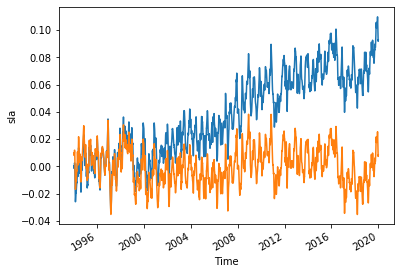

In [4]:
# find global means for comparison
stacked = daily_sla.stack(allpoints=['latitude','longitude'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
global_mean.plot()

# find global means for comparison
stacked = daily_sla_dtrnd.stack(allpoints=['latitude','longitude'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
global_mean_dtrnd.plot()
plt.legend

# Downsample to Monthly and Seasonal Temporal Resolution

In [5]:
%%time
# monthly
mon_sla_dtrnd = daily_sla_dtrnd.resample(time='1MS').mean(dim="time")
# seasonal
seas_sla_dtrnd = daily_sla_dtrnd.resample(time='QS-DEC').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 6min 6s, sys: 1min 1s, total: 7min 7s
Wall time: 14.4 s


# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [6]:
%%time
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# get months
month_length = daily_sla_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
sla_seas_clim_dtrnd = (daily_sla_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
sla_seas_clim_dtrnd = sla_seas_clim_dtrnd.where(sla_seas_clim_dtrnd != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

# -------------------------------------------
# monthly
# -------------------------------------------

sla_mon_clim_dtrnd = daily_sla_dtrnd.groupby('time.month').mean('time') 

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 1min 22s, sys: 15 s, total: 1min 37s
Wall time: 14.4 s


# Find Anomalies

In [7]:
%%time

# # daily data - monthly climatology
# daily_sla_mon_anom_dtrnd = daily_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# monthly avg data - monthly climatology
mon_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# # monthly avg data - seasonal climatology
# seas_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.season') - sla_seas_clim_dtrnd

# seasonal avg data - seasonal climatology
seas_sla_seas_anom_dtrnd = mon_sla_dtrnd.groupby('time.season') - sla_seas_clim_dtrnd

CPU times: user 7.27 s, sys: 1.74 s, total: 9 s
Wall time: 548 ms


In [8]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': daily_sla_dtrnd.longitude,
                    'lat': daily_sla_dtrnd.latitude,
                    'time': daily_sla_dtrnd.time})

# add variables to dataset

ds["daily_sla"]=(['time','lat', 'lon'],  daily_sla_dtrnd)
ds["mon_sla"]=xr.DataArray(mon_sla_dtrnd,dims = ['month_time','lat', 'lon'],
                     coords =[mon_sla_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["seas_sla"]=xr.DataArray(seas_sla_dtrnd,dims = ['season_time','lat', 'lon'],
                     coords =[seas_sla_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])

# clim
ds["sla_mon_clim"]=xr.DataArray(sla_mon_clim_dtrnd,dims = ['month','lat', 'lon'],
                     coords =[sla_mon_clim_dtrnd.month,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["sla_seas_clim"]=xr.DataArray(sla_seas_clim_dtrnd,dims = ['season','lat', 'lon'],
                     coords =[sla_seas_clim_dtrnd.season,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])

# anom
ds["mon_sla_mon_anom"]=xr.DataArray(mon_sla_mon_anom_dtrnd,dims = ['month_time','lat', 'lon'],
                     coords =[mon_sla_mon_anom_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])
ds["seas_sla_seas_anom"]=xr.DataArray(seas_sla_seas_anom_dtrnd,dims = ['season_time','lat', 'lon'],
                     coords =[seas_sla_seas_anom_dtrnd.time,daily_sla_dtrnd.latitude,daily_sla_dtrnd.longitude])

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds

<xarray.Dataset>
Dimensions:             (lat: 200, latitude: 200, lon: 340, longitude: 340, month: 12, month_time: 312, season: 4, season_time: 105, time: 9496)
Coordinates:
  * season_time         (season_time) datetime64[ns] 1993-12-01 ... 2019-12-01
  * longitude           (longitude) float64 35.12 35.38 35.62 ... 119.6 119.9
  * latitude            (latitude) float64 -19.88 -19.62 -19.38 ... 29.62 29.88
  * lon                 (lon) float64 35.12 35.38 35.62 ... 119.4 119.6 119.9
  * lat                 (lat) float64 -19.88 -19.62 -19.38 ... 29.38 29.62 29.88
  * time                (time) datetime64[ns] 1994-01-01 ... 2019-12-31
  * month_time          (month_time) datetime64[ns] 1994-01-01 ... 2019-12-01
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    daily_sla           (time, lat, lon) float64 0.1093 0.06987 ... nan nan
    mon_sla             (month_time, lat, lon) float64 0.0